### Importing Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [11]:
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 1.26.4
Pandas version: 2.2.3


### Load and Prepare Data

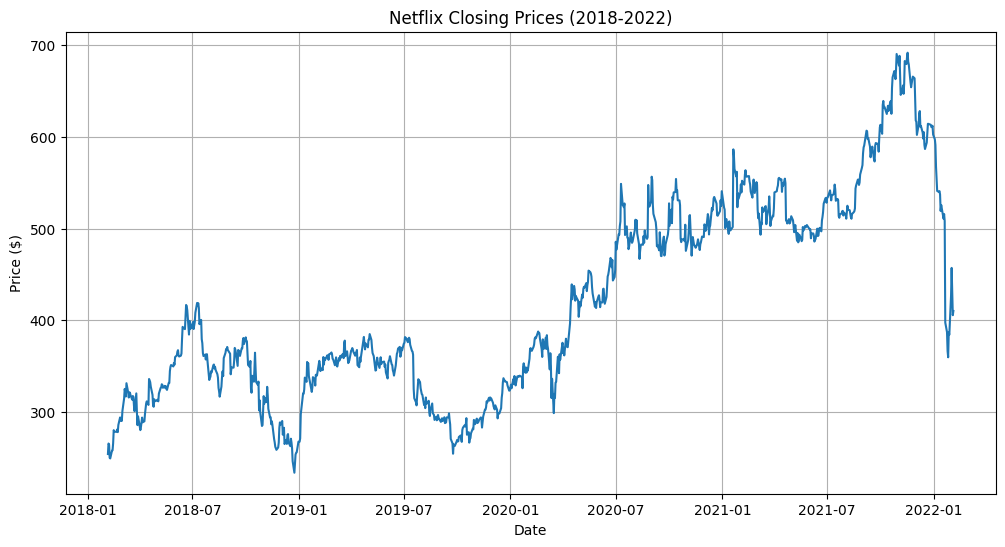

In [12]:
# Load data
path = r"C:\Users\ADMIN\Desktop\Stock-Price-Forecasting-System-Using-Apache-Spark\data\raw\NFLX.csv"
df = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
df.sort_index(inplace=True)

# Use 'Close' prices
ts = df['Close']

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Netflix Closing Prices (2018-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid()
plt.show()

## Check Stationarity

In [13]:
# Augmented Dickey-Fuller Test:

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v:.3f}')

adf_test(ts)

ADF Statistic: -1.813
p-value: 0.374
Critical Values:
   1%: -3.437
   5%: -2.864
   10%: -2.568


Conclusion: The series is non-stationary (p-value > 0.05). Apply differencing.

## First Differencing

In [14]:
ts_diff = ts.diff().dropna()
# ADF test on differenced data
adf_test(ts_diff)

ADF Statistic: -14.242
p-value: 0.000
Critical Values:
   1%: -3.437
   5%: -2.864
   10%: -2.568


Conclusion: Differenced data is now stationary (p-value < 0.05). Set d=1.

## Identify ARIMA Order (p, d, q)

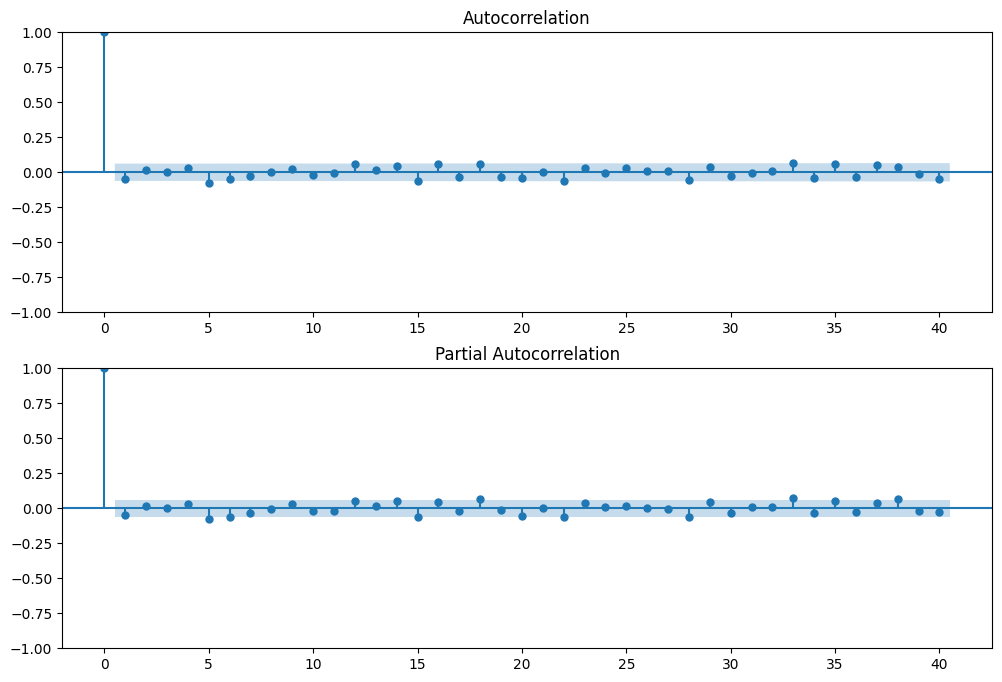

In [15]:
# ACF/PACF Plots:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts_diff, lags=40, ax=ax1)
plot_pacf(ts_diff, lags=40, ax=ax2)
plt.show()

## Split Data into Train/Test

In [ ]:
split_date = '2021-12-21'
train = ts[:split_date]
test = ts[split_date:]
print(f'Train size: {len(train)}, Test size: {len(test)}')

Train size: 964, Test size: 46


## Fit ARIMA Model

In [17]:
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  964
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3608.099
Date:                Mon, 24 Feb 2025   AIC                           7222.197
Time:                        22:32:52   BIC                           7236.807
Sample:                             0   HQIC                          7227.760
                                - 964                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0508      0.302     -0.168      0.866      -0.642       0.540
ma.L1         -0.0467      0.305     -0.153      0.879      -0.645       0.552
sigma2       105.1691      2.257     46.592      0.0

MAE: 80.56
RMSE: 117.05


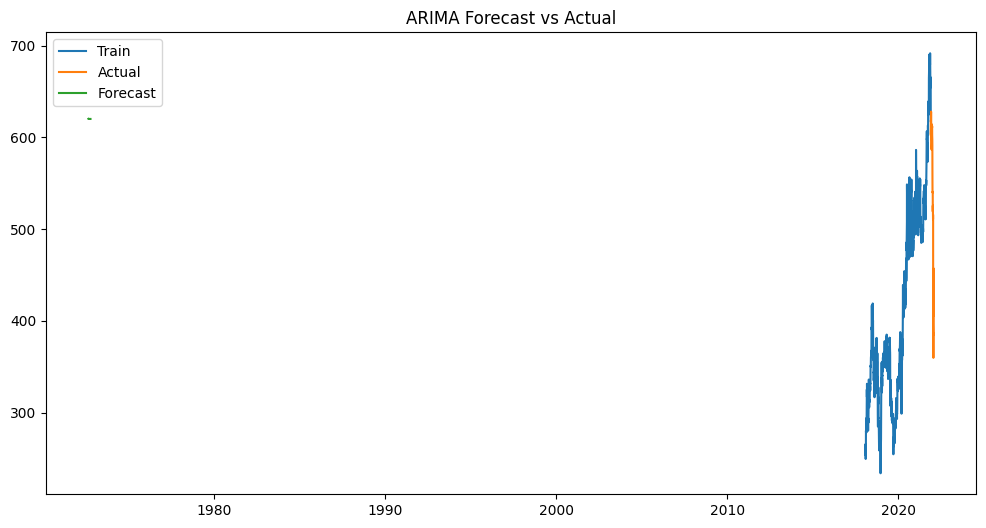

In [18]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Calculate metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()